 250321T0722_9 adc_b3_ch3             


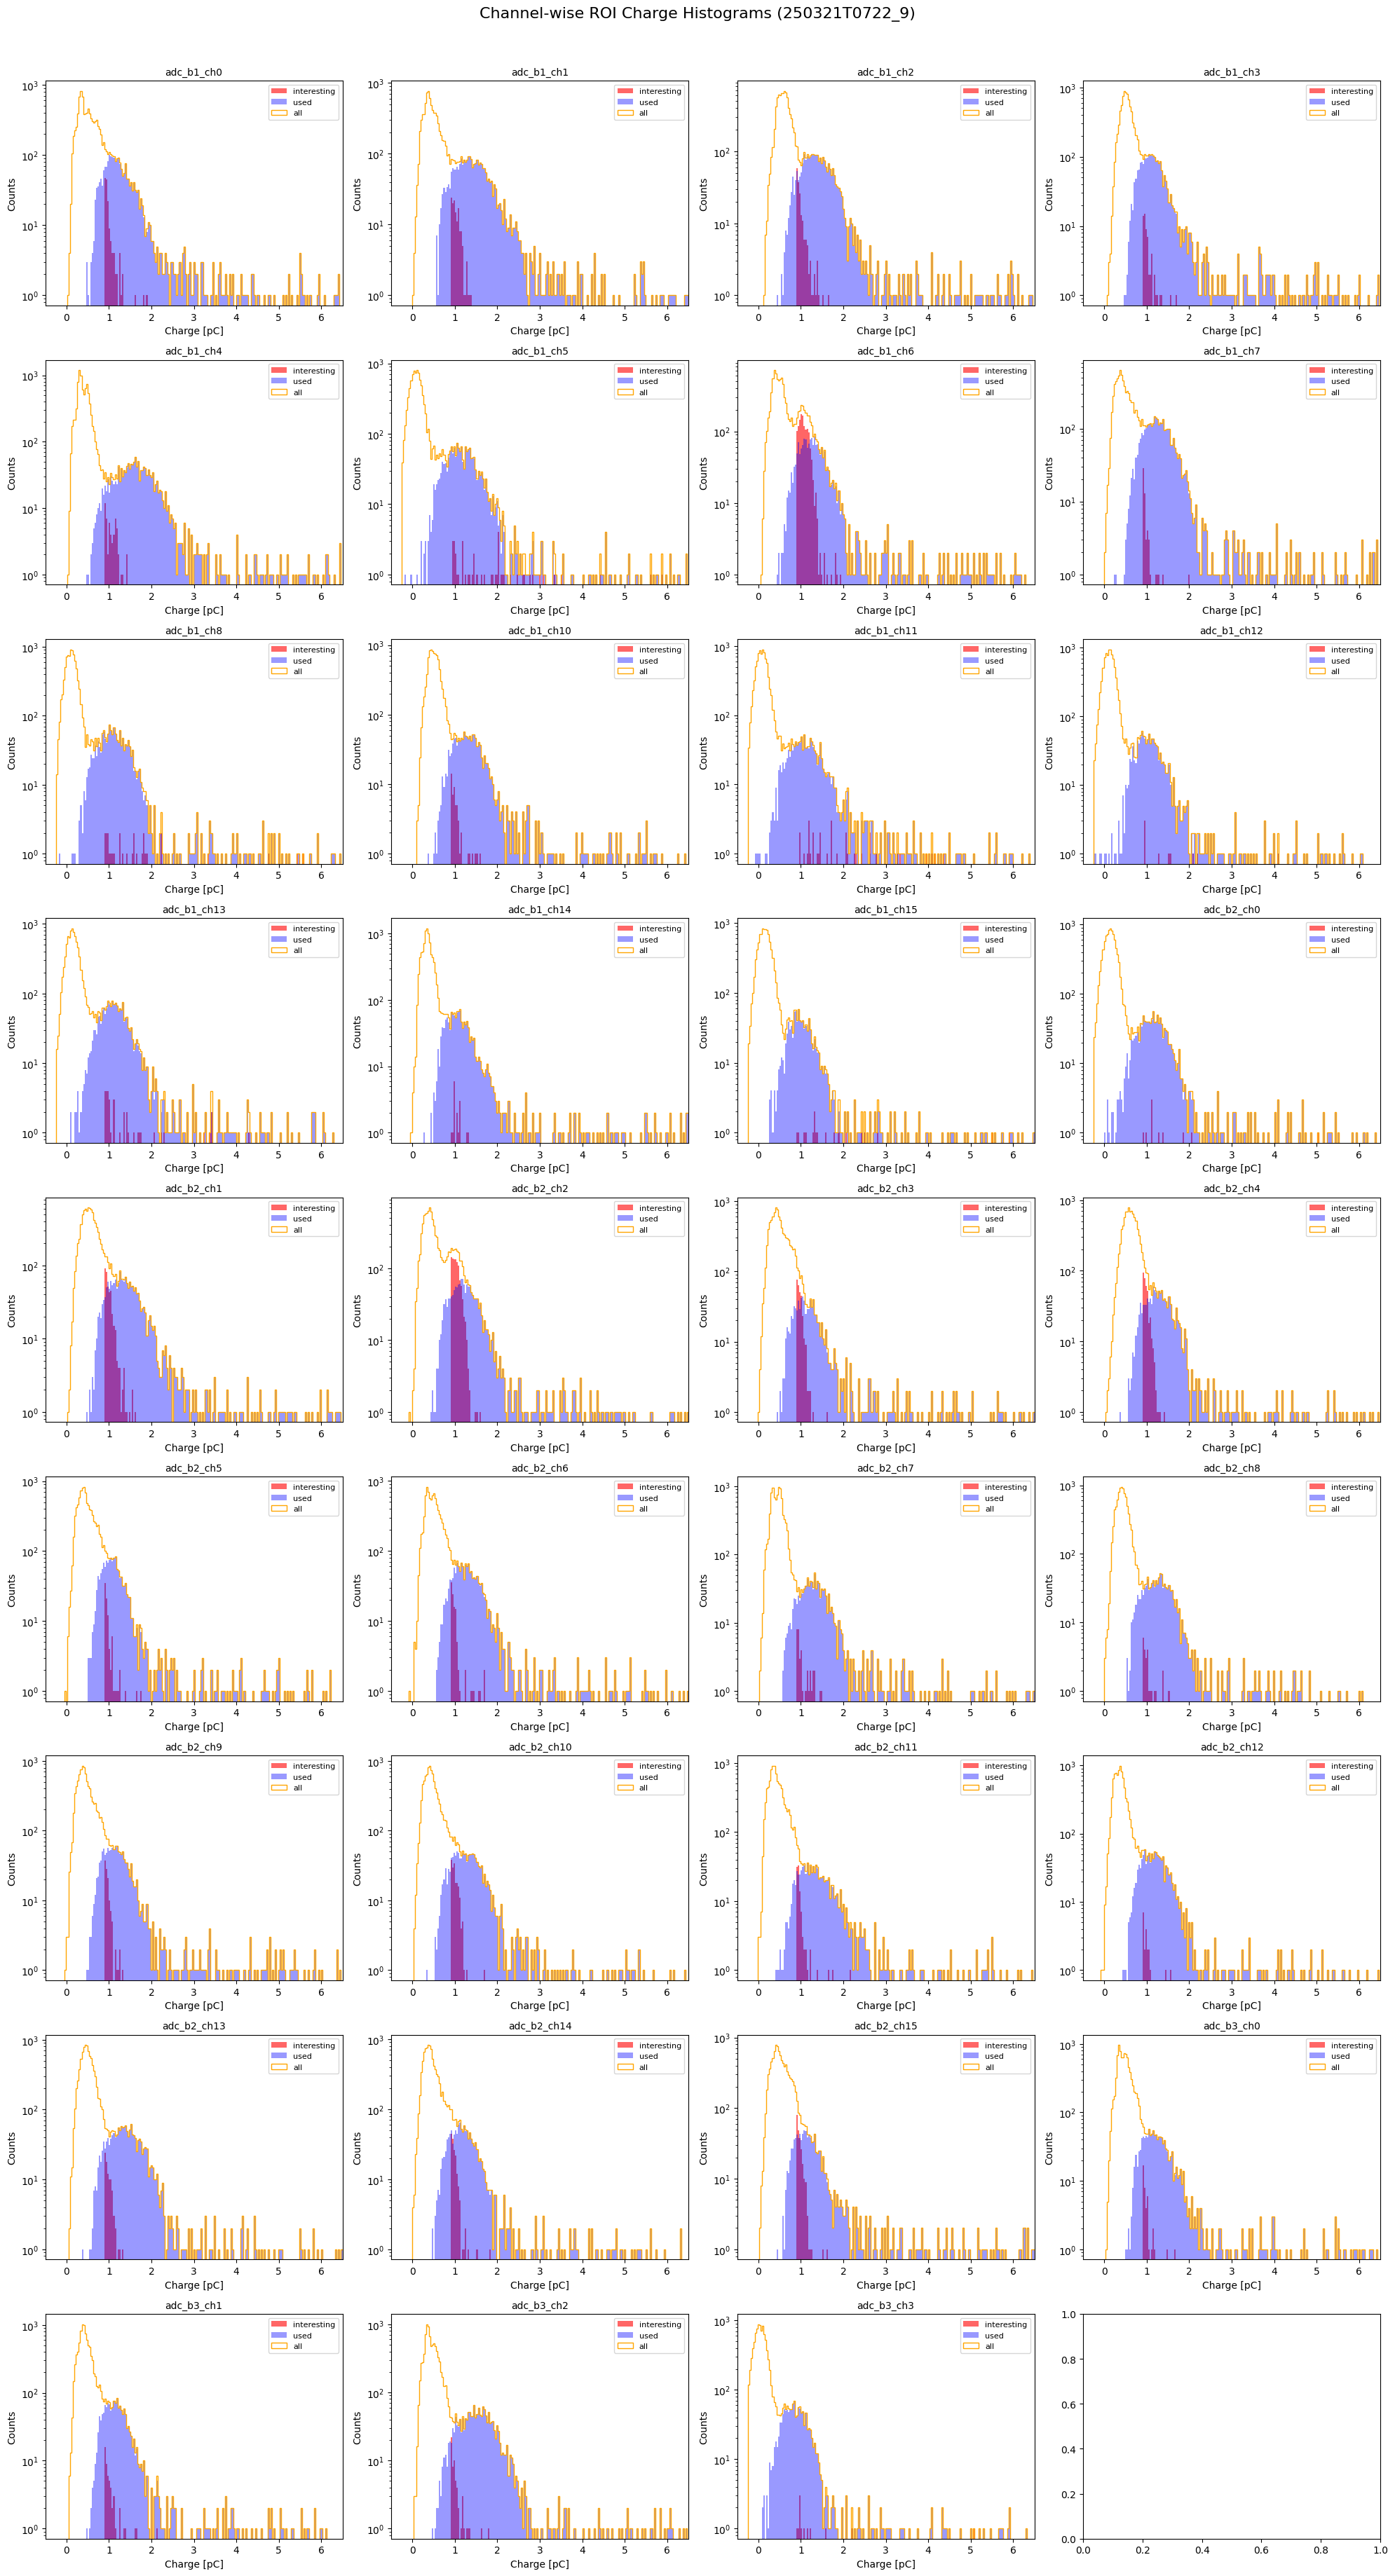

In [24]:
import sys
import os
import re
import math
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import gamma
import uproot
import pandas as pd

# 별도 모듈에서 변수 및 함수 불러오기 (채널 정보, 에러 계산 함수 등)
from wbls_vars import *
from wbls_functions import *

# expDecay 함수 (Fourier 필터링에 사용)
def expDecay(f, f0, d, offset):
    return offset + f0 * np.exp(-d * f)

# ROI (Region of Interest) 선택 함수
def findRoi(eventMaximumTimes, peakMask=None, roiLength=40):
    density = []
    for v in range(int(np.max(eventMaximumTimes[peakMask]))):
        ins = np.sum([v < time < v + roiLength for time in eventMaximumTimes[peakMask]])
        density.append(ins)
    roiStart = int(density.index(max(density)))
    return (roiStart, roiStart + roiLength)

# Polya(감마) 로그 피팅 함수 정의
def polya_log(x, N, k, theta):
    out = np.full_like(x, -1e10, dtype=np.float64)
    mask = (x > 0)
    out[mask] = (np.log(N)
                 + (k - 1) * np.log(x[mask])
                 - (x[mask] / theta)
                 - np.log(gamma(k))
                 - k * np.log(theta))
    return out

# 전역 변수
voltageFactor = 2000 / (2**14 - 1)
unusedevts = {}
interestedevts = {}

# 스킵할 채널 목록과 사용 채널 선택
skip = ['adc_b1_ch9', 'adc_b4_ch13']
channels = [channel for channel in dataChannelNamesSorted30t if channel not in skip]

# 데이터 디렉토리 및 파일
directory = '/media/disk_i/30t-DATA/raw_root/phase0/'
inFiles = ['majority_test_250321T0722_9.root']

# subplot 설정
nChannels = len(channels)
nCols = 4
nRows = math.ceil(nChannels / nCols)
fig, axs = plt.subplots(nRows, nCols, figsize=(5 * nCols, 4 * nRows), squeeze=False)

# 루트 파일 처리
for root in inFiles:
    if os.stat(directory + root).st_size < 10000000:
        print("file size small")
        continue

    dateTimeBatch = re.search(r'(\d{6})T\d{4}_\d{1,}', root).group(0)
    print('                                      \r', dateTimeBatch, end='\r')

    try:
        rootFileOpen = uproot.open(directory + root)['daq']
        eventsByChannel = rootFileOpen.arrays(filter_name=channels, library='np')
        alphaEvents = rootFileOpen.arrays(filter_name='adc_b4_ch23', library='np')['adc_b4_ch23']
    except Exception as e:
        print(' ' + dateTimeBatch, ' no good: ', e)
        continue

    alphaEventMaxima = np.empty(0)
    alphaEventMaximumTimes = np.empty(0)
    for event in alphaEvents:
        normPosEvent = np.median(event) - event
        alphaEventMaxima = np.append(alphaEventMaxima, np.max(normPosEvent) * voltageFactor)
        alphaEventMaximumTimes = np.append(alphaEventMaximumTimes, np.argmax(normPosEvent) * 2)
    alphaMask = alphaEventMaxima > 50

    for i, channel in enumerate(channels):
        print('                                      \r', dateTimeBatch, channel, end='\n' if channel == channels[-1] else '\r')
        try:
            events = eventsByChannel[channel]
        except Exception as e:
            print(f"Channel {channel} error: {e}")
            continue

        events = (np.median(events) - events) * voltageFactor
        fracMask = [(not bool(event % 1)) for event in range(len(events))]
        preProcessingMask = np.logical_and(alphaMask, fracMask)
        events = events[preProcessingMask]

        if len(events) == 0:
            print("No event in mask")
            continue

        eventMaxima = np.empty(0)
        eventMaximumTimes = np.empty(0)
        averageSignalAmplitude = np.zeros(int(len(events[0]) / 2))
        averageNoiseAmplitude = np.zeros(int(len(events[0]) / 2))
        addedSignalEvents = 0
        addedNoiseEvents = 0

        try:
            for event in events:
                if (np.min(event) < -2) and (np.max(event) < 5):
                    addedNoiseEvents += 1
                    ft_amp = np.abs(np.fft.fft(event))[:len(event)//2]
                    averageNoiseAmplitude += ft_amp
                if (np.min(event) > -5) and (np.max(event) > 10):
                    addedSignalEvents += 1
                    ft_amp = np.abs(np.fft.fft(event))[:len(event)//2]
                    averageSignalAmplitude += ft_amp

            noiseBad = addedNoiseEvents > 0.01 * len(events)
            if noiseBad:
                averageNoiseAmplitude /= addedNoiseEvents
                averageSignalAmplitude /= addedSignalEvents
                freqs = np.fft.fftfreq(len(events[0]), d=2e-9)[:len(events[0])//2]
                popt, _ = curve_fit(expDecay, freqs[:len(freqs)//2], averageSignalAmplitude[:len(freqs)//2], p0=[200, 4e-8, 10])
                bigPhi = np.power(expDecay(freqs, *popt), 2) / (np.power(expDecay(freqs, *popt), 2) + np.power(averageNoiseAmplitude, 2))
                bigPhiMask = np.concatenate([bigPhi[::-1], bigPhi])
                for n, event in enumerate(events):
                    ft = np.fft.fftshift(np.fft.fft(event))
                    ft *= bigPhiMask
                    ft = np.fft.ifftshift(ft)
                    filtered = np.abs(np.fft.ifft(ft)) - np.median(event)
                    events[n] = filtered
                    eventMaxima = np.append(eventMaxima, np.max(filtered))
                    eventMaximumTimes = np.append(eventMaximumTimes, np.argmax(filtered) * 2)
            else:
                for event in events:
                    eventMaxima = np.append(eventMaxima, np.max(event))
                    eventMaximumTimes = np.append(eventMaximumTimes, np.argmax(event) * 2)

            regionOfInterestMaxima = np.empty(0)
            regionOfInterestMinima = np.empty(0)
            regionOfInterestCharges = np.empty(0)

            for event in events:
                max_idx = np.argmax(event)
                left_idx = max(0, max_idx - 10)
                right_idx = min(len(event), max_idx + 20)
                roi = event[left_idx:right_idx]
                regionOfInterestMaxima = np.append(regionOfInterestMaxima, np.max(roi))
                regionOfInterestMinima = np.append(regionOfInterestMinima, np.min(roi))
                regionOfInterestCharges = np.append(regionOfInterestCharges, np.sum(roi) * 2 * (1/50))

        except Exception as e:
            print(f"Error processing {channel}: {e}")
            continue

        pedestalMask = regionOfInterestMaxima > 2.5
        eventMinMask = regionOfInterestMinima > -5
        postProcessingMask = np.logical_and(pedestalMask, eventMinMask)

        histData = regionOfInterestCharges[postProcessingMask]
        chargemask = regionOfInterestCharges > 0.9
        IntMask = np.logical_and(chargemask, ~postProcessingMask)
        weridoData = regionOfInterestCharges[IntMask]
        interestedevts = events[IntMask]

        # === Plotting on subplot ===
        row = i // nCols
        col = i % nCols
        ax = axs[row][col]

        ax.hist(weridoData, bins=np.linspace(-0.25, 6.5, 201), color='red', alpha=0.6, label='interesting')
        ax.hist(histData, bins=np.linspace(-0.25, 6.5, 201), color='blue', alpha=0.4, label='used')
        ax.hist(regionOfInterestCharges, bins=np.linspace(-0.25, 6.5, 201), histtype='step', color='orange', label='all')

        ax.set_title(channel, fontsize=10)
        ax.set_xlim(-0.5, 6.5)
        ax.set_yscale('log')
        ax.set_xlabel('Charge [pC]')
        ax.set_ylabel('Counts')
        ax.legend(fontsize=8)

# 전체 layout 정리 및 출력
plt.tight_layout()
plt.suptitle(f"Channel-wise ROI Charge Histograms ({dateTimeBatch})", fontsize=16, y=1.02)
plt.savefig(f"{dateTimeBatch}_all_channel_histograms.png", bbox_inches='tight')
plt.show()


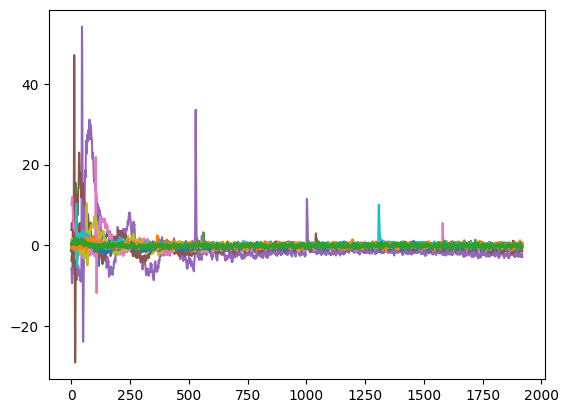

In [25]:
plt.figure()
for i in range(len(interestedevts)):
    plt.plot(interestedevts[i])
plt.show()

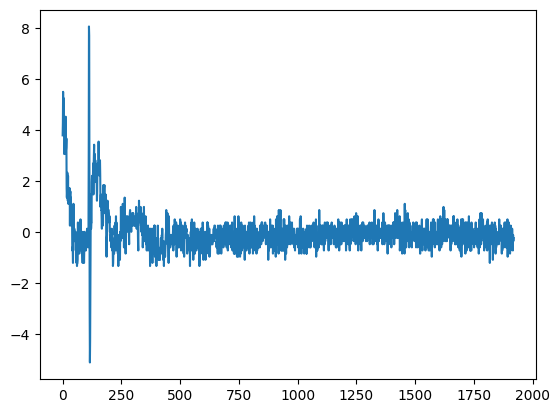

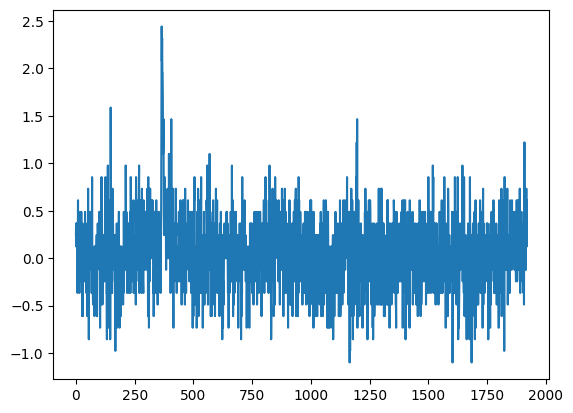

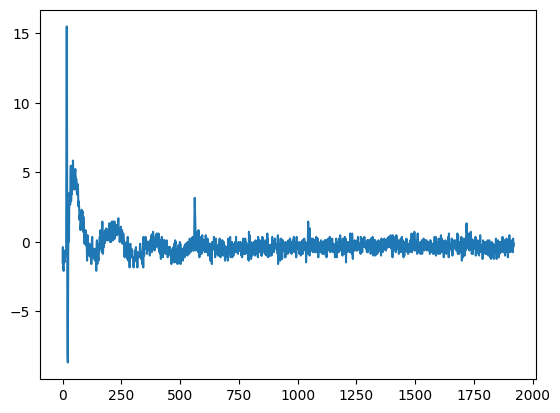

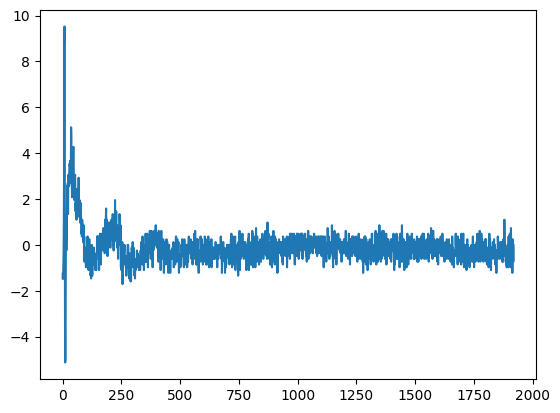

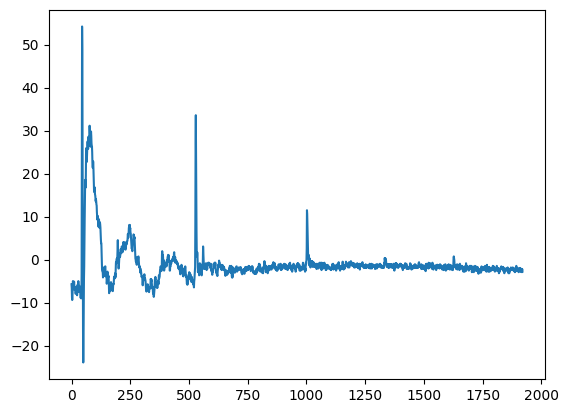

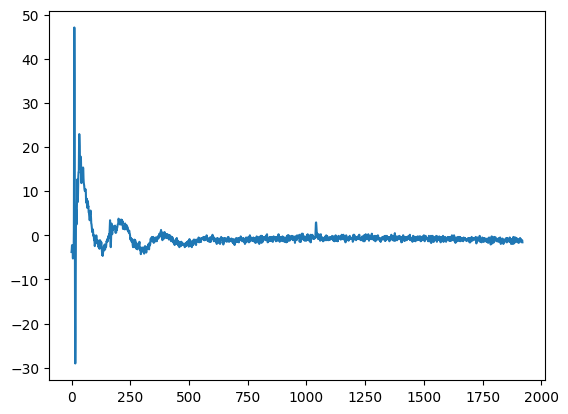

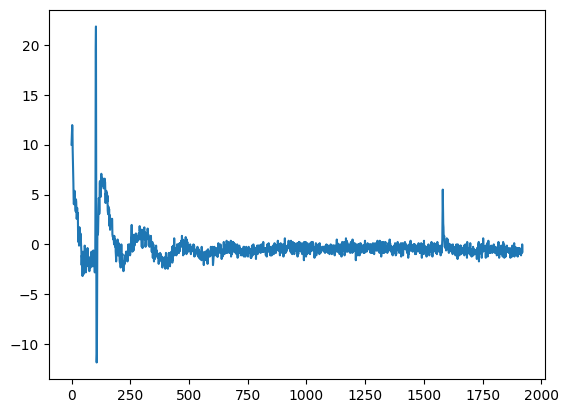

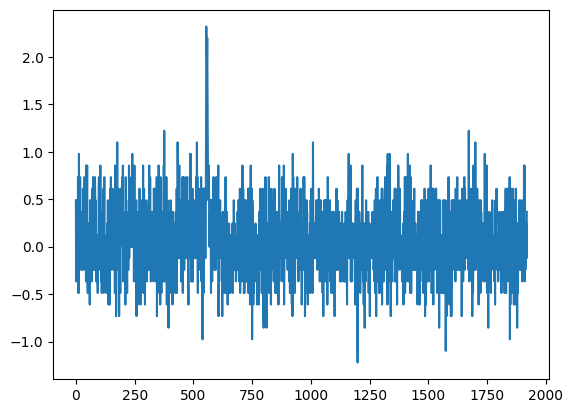

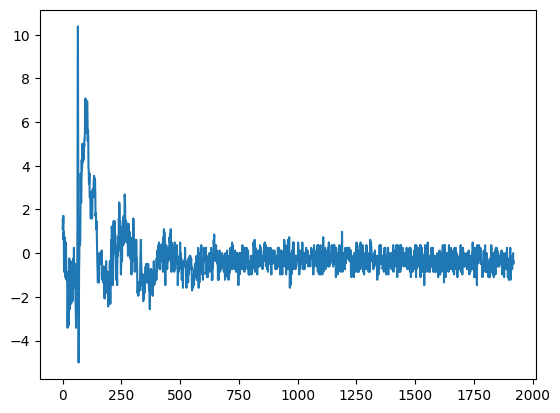

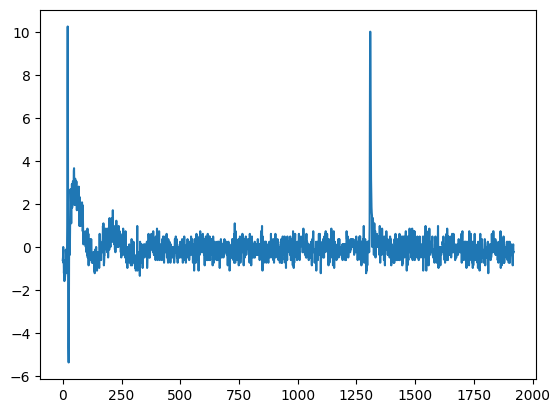

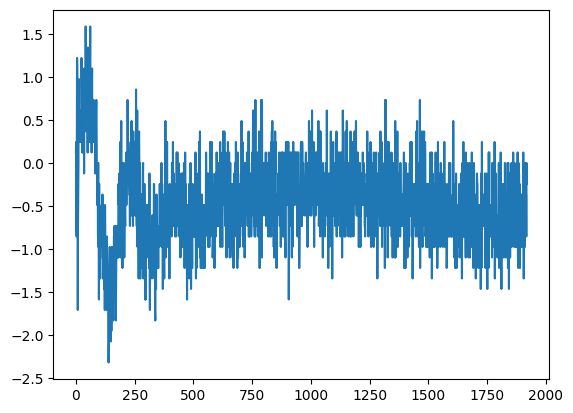

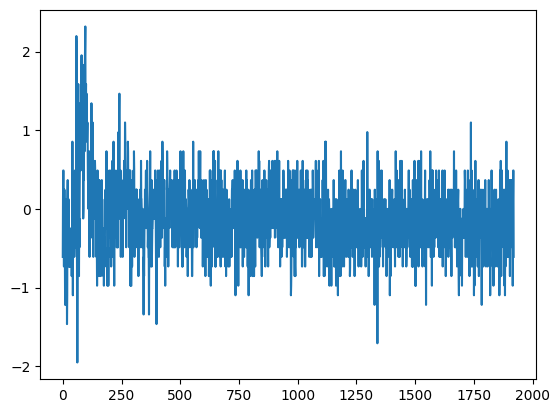

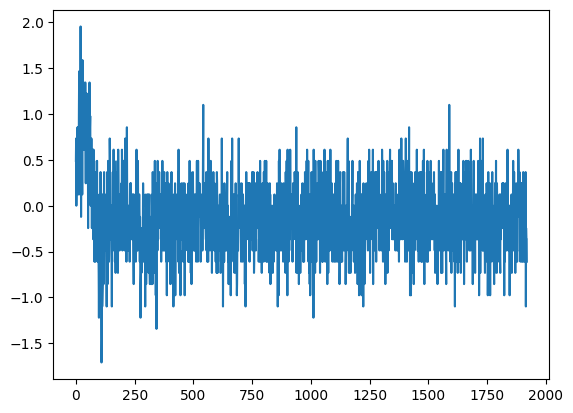

In [26]:
plt.figure()
for i in range(len(interestedevts)):
    plt.plot(interestedevts[i])
    plt.show()